In [1]:
%%capture
!pip install einops

In [2]:
import gc
import torch
import einops
import wandb
import pandas as pd
import numpy as np
import xarray as xr
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipywidgets as widgets

from torch import nn
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold

In [3]:
data_dir = '/kaggle/input/optiver-realized-volatility-prediction'
n_features = 21
n_stocks = 112
n_seconds = 600
# if coarsen > 1, data will be aggregated per this number of seconds,
# use this to reduce memory usage, though during competition I trained on full data, 
# so I'm not sure how it can affect model performance
coarsen = 3 

In [4]:
def prepare_data(stock_id, stock_ind, set, time_ids, coarsen, norm, out):
    df_book = pd.read_parquet(f'{data_dir}/book_{set}.parquet/stock_id={stock_id}')
    df_min_second = df_book.groupby('time_id').agg(min_second=('seconds_in_bucket', 'min'))
    df_book = df_book.merge(df_min_second, left_on='time_id', right_index=True) \
        .eval('seconds_in_bucket = seconds_in_bucket - min_second') \
        .drop('min_second', axis=1)
    df_trade = pd.read_parquet(f'{data_dir}/trade_{set}.parquet/stock_id={stock_id}') \
        .merge(df_min_second, left_on='time_id', right_index=True) \
        .eval('seconds_in_bucket = seconds_in_bucket - min_second') \
        .drop('min_second', axis=1)
    df = pd.merge(df_book, df_trade, on=['time_id', 'seconds_in_bucket'], how='outer')
    df['stock_id'] = stock_id
    df = df.set_index(['stock_id', 'time_id', 'seconds_in_bucket'])
    df = df.to_xarray().astype('float32')
    df = df.reindex({'time_id': time_ids, 'seconds_in_bucket': np.arange(n_seconds)})
    for name in ['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2', 
         'bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']:
        df[name] = df[name].ffill('seconds_in_bucket')
    df['wap1'] = (df.bid_price1 * df.ask_size1 + df.ask_price1 * df.bid_size1) / (df.bid_size1 + df.ask_size1)
    df['wap2'] = (df.bid_price2 * df.ask_size2 + df.ask_price2 * df.bid_size2) / (df.bid_size2 + df.ask_size2)
    df['log_return1'] = np.log(df.wap1).diff('seconds_in_bucket')
    df['log_return2'] = np.log(df.wap2).diff('seconds_in_bucket')
    df['current_vol'] = (df.log_return1 ** 2).sum('seconds_in_bucket') ** 0.5
    df['current_vol_2nd_half'] = (df.log_return1[..., 300:] ** 2).sum('seconds_in_bucket') ** 0.5
    if coarsen > 1:
        mean_features = ['ask_price1', 'ask_price2', 'bid_price1', 'bid_price2',  'ask_size1', 'ask_size2',
               'bid_size1', 'bid_size2', 'price']
        sum_features = ['size', 'order_count']
        
        df = xr.merge((df[mean_features].coarsen({'seconds_in_bucket': coarsen}, coord_func='min').mean(), 
                       df[sum_features].coarsen({'seconds_in_bucket': coarsen}, coord_func='min').sum(), 
                       df[['current_vol', 'current_vol_2nd_half']]))
        df['wap1'] = (df.bid_price1 * df.ask_size1 + df.ask_price1 * df.bid_size1) / (df.bid_size1 + df.ask_size1)
        df['wap2'] = (df.bid_price2 * df.ask_size2 + df.ask_price2 * df.bid_size2) / (df.bid_size2 + df.ask_size2)
        df['log_return1'] = np.log(df.wap1).diff('seconds_in_bucket')
        df['log_return2'] = np.log(df.wap2).diff('seconds_in_bucket')
    
    df['spread1'] = df.ask_price1 - df.bid_price1
    df['spread2'] = df.ask_price2 - df.ask_price1
    df['spread3'] = df.bid_price1 - df.bid_price2
    df['total_volume'] = df.ask_size1 + df.ask_size2 + df.bid_size1 + df.bid_size2
    df['volume_imbalance1'] = df.ask_size1 + df.ask_size2 - df.bid_size1 - df.bid_size2
    df['volume_imbalance2'] = (df.ask_size1 + df.ask_size2 - df.bid_size1 - df.bid_size2) / df.total_volume
    for name in ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2', 'size', 'order_count', 'total_volume']:
        df[name] = np.log1p(df[name])
#         df[name] = df[name].rank('seconds_in_bucket')
    df['volume_imbalance1'] = np.sign(df['volume_imbalance1']) * np.log1p(abs(df['volume_imbalance1']))

    df = df.fillna({'ask_price1': 1, 'ask_price2': 1, 'bid_price1': 1, 'bid_price2': 1,  'ask_size1': 0, 'ask_size2': 0,
               'bid_size1': 0, 'bid_size2': 0, 'price': 1, 'size': 0, 'order_count': 0, 'wap1': 1, 'wap2': 1,
               'log_return1': 0, 'log_return2': 0, 'spread1': 0, 'spread2': 0, 'spread3': 0, 'total_volume': 0,
               'volume_imbalance1': 0, 'volume_imbalance2': 0, 'current_vol': 0, 'current_vol_2nd_half': 0})
    features = ['ask_price1', 'ask_price2', 'bid_price1', 'bid_price2',  'ask_size1', 'ask_size2',
               'bid_size1', 'bid_size2', 'price', 'size', 'order_count', 'wap1', 'wap2',
               'log_return1', 'log_return2', 'spread1', 'spread2', 'spread3', 'total_volume',
               'volume_imbalance1', 'volume_imbalance2']
    extra = ['current_vol', 'current_vol_2nd_half']
    
    if norm is not None:
        mean = norm['mean'].sel(stock_id=stock_id)
        std = norm['std'].sel(stock_id=stock_id)
    else:
        mean = df.mean(('time_id', 'seconds_in_bucket')).drop(['current_vol', 'current_vol_2nd_half'])
        std = df.std(('time_id', 'seconds_in_bucket')).drop(['current_vol', 'current_vol_2nd_half'])
        
    df.update((df - mean) / std)
    df = df.astype('float32')

    out[:, stock_ind] = einops.rearrange(df[features].to_array().values, 'f () t sec -> t sec f')
    return df[extra], {'mean': mean, 'std': std}

class OptiverDataset(Dataset):
    def __init__(self, features_data, extra_data, mode, time_ids):
        self.features_data = features_data
        self.extra_data = extra_data
        self.time_ids = time_ids
        self.mode = mode

    def __len__(self):
        if self.mode == 'single-stock':
            return len(self.time_ids) * n_stocks
        elif self.mode == 'multi-stock':
            return len(self.time_ids)

    def __getitem__(self, i):
        if self.mode == 'single-stock':
            time_id = self.time_ids[i // n_stocks]
            time_ind = self.extra_data.indexes['time_id'].get_loc(time_id)
            stock_ind = i % n_stocks
            stock_id = self.extra_data.indexes['stock_id'][stock_ind]
            return {
                'data': self.features_data[time_ind], # (112, 600, 21)
                'target': self.extra_data['target'].values[time_ind, stock_ind],  # (1,)
                'current_vol': self.extra_data['current_vol'].values[time_ind, stock_ind],  # (1,) 
                'current_vol_2nd_half': self.extra_data['current_vol_2nd_half'].values[time_ind, stock_ind],  # (1,)                
                'time_id': time_id,
                'stock_id': stock_id,
                'stock_ind': stock_ind
            }
        elif self.mode == 'multi-stock':
            time_id = self.time_ids[i]
            time_ind = self.extra_data.indexes['time_id'].get_loc(time_id)
            return {
                'data': self.features_data[time_ind], # (112, 600, 21)
                'target': self.extra_data['target'].values[time_ind],  # (112,)
                'current_vol': self.extra_data['current_vol'].values[time_ind],  # (112,) 
                'current_vol_2nd_half': self.extra_data['current_vol_2nd_half'].values[time_ind],  # (112,)
                'time_id': time_id,
            }
    
class TimeAttention(nn.Module):
    def __init__(self, steps):
        super().__init__()
        self.steps = steps
        self.weights = nn.Parameter(torch.zeros(steps))
    
    def forward(self, x):
        # x: (b, st, t, f)
        attn = F.softmax(self.weights, 0)
        x = torch.einsum('b s t f, t -> b s f', x, attn)
        return x

# You can experiment with other ideas for stock attention: maybe it could be
# something like MultiHeadAttention module with keys and queries that depends on current input, 
# maybe it could be a linear combination of all stocks (full connected layer), 
# maybe you can try sparse softmax
class StockAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((n_stocks, n_stocks)))
        self.bias = nn.Parameter(torch.zeros(n_stocks))
        self.fc_combine = nn.Linear(dim * 2, dim)

    def forward(self, x):
        # x: (b, st, t, f)
        attn = F.softmax(self.weight + self.bias[None, :], dim=-1) # (st, st)
        y = torch.einsum('b i ..., j i -> b j ...', x, attn)
        x = torch.cat((x, y), -1)
        x = self.fc_combine(x)
        return x    
    
class OptiverModel(pl.LightningModule):
    def __init__(self, mode='multi-stock', dim=32, conv1_kernel=3, rnn_layers=2, rnn_dropout=0.3, 
                 n_features=21, aux_loss_weight=1.0):
        super().__init__()
        self.save_hyperparameters()
        self.stock_emb = nn.Embedding(n_stocks, dim)
        self.stock_emb.weight.data.normal_(0, 0.2)
        self.conv1 = nn.Conv1d(n_features, dim, conv1_kernel, conv1_kernel)
        self.conv2 = nn.Conv1d(dim, dim, 1, 1)
        self.norm1 = nn.LayerNorm([n_stocks, dim])
        self.norm2 = nn.LayerNorm([n_stocks, dim])
        self.rnn = nn.GRU(dim, dim, rnn_layers, batch_first=True, dropout=rnn_dropout)
        self.timesteps_attn = TimeAttention(600 // conv1_kernel // coarsen)
        self.timesteps_attn2 = TimeAttention(300 // conv1_kernel // coarsen)
        self.stock_attn = StockAttention(dim)
        self.fc_out1 = nn.Linear(dim, 1)
        self.fc_out2 = nn.Linear(dim, 1)
        self.history = pd.DataFrame()

    def forward(self, x, stock_ind=None):
        # x: (b, st, t, f)
        x = einops.rearrange(x, 'b st t f -> (b st) f t')
        x = self.conv1(x)
        x = einops.rearrange(x, '(b st) f t -> b t st f', st=n_stocks)
        x = F.gelu(x)
        x = self.norm1(x)
        x = einops.rearrange(x, 'b t st f -> (b st) f t')
        x = self.conv2(x)
        x = einops.rearrange(x, '(b st) f t -> b t st f', st=n_stocks)
        x = F.gelu(x)
        x = self.norm2(x)
        x = einops.rearrange(x, 'b t st f -> b st t f')
        x = self.stock_attn(x)
        x = x + self.stock_emb.weight[None, :, None, :]
        if self.hparams.mode == 'single-stock':
            x = x[torch.arange(len(x)), stock_ind][:, None]
        x = einops.rearrange(x, 'b st t f -> (b st) t f')
        x = self.rnn(x)[0]
        x = einops.rearrange(x, '(b st) t f -> b st t f', st=n_stocks if self.hparams.mode == 'multi-stock' else 1)
        x1 = self.timesteps_attn(x)
        x2 = self.timesteps_attn2(x[:, :, :self.timesteps_attn2.steps, :])
        x1 = self.fc_out1(x1)
        x2 = self.fc_out2(x2)
        x1 = x1 * 0.63393 - 5.762331
        x2 = x2 * 0.67473418 - 6.098946
        x1 = torch.exp(x1)
        x2 = torch.exp(x2)
        if self.hparams.mode == 'single-stock':
            return {
                'vol': x1[:, 0, 0], # (b,)
                'vol2': x2[:, 0, 0] # (b,)
            }
        else:        
            return {
                'vol': x1[..., 0], # (b, st)
                'vol2': x2[..., 0] # (b, st)
            }

    def training_step(self, batch, batch_ind):
        out = self.common_step(batch, 'train')
        return out

    def validation_step(self, batch, batch_ind):
        return self.common_step(batch, 'valid')

    def common_step(self, batch, stage):
        out = self(batch['data'], batch['stock_ind'] if self.hparams.mode == 'single-stock' else None)
        mask1 = ~torch.isnan(batch['target'])
        target1 = torch.where(mask1, batch['target'], torch.tensor(1.0, device=self.device))
        mask2 = batch['current_vol_2nd_half'] > 0
        target2 = torch.where(mask2, batch['current_vol_2nd_half'], torch.tensor(1.0, device=self.device))
        vol_loss = (((out['vol'] - target1) / target1) ** 2)[mask1].mean() ** 0.5
        vol2_loss = (((out['vol2'] - target2) / target2) ** 2)[mask2].mean() ** 0.5
        loss = vol_loss + self.hparams.aux_loss_weight * vol2_loss
        self.log(f'{stage}/loss', loss.item(), on_step=False, on_epoch=True)
        self.log(f'{stage}/vol_loss', vol_loss.item(), on_step=False, on_epoch=True)
        self.log(f'{stage}/vol2_loss', vol2_loss.item(), on_step=False, on_epoch=True)
        return {
            'loss': loss,
            'target': batch['target'],
            'vol': out['vol'].detach(),
            'time_id': batch['time_id']
        }

    def common_epoch_end(self, outs, stage):
        target = torch.cat([x['target'] for x in outs])
        vol = torch.cat([x['vol'] for x in outs])
        time_ids = torch.cat([x['time_id'] for x in outs])
        mask = ~torch.isnan(target)
        target = torch.where(mask, target, torch.tensor(1.0, device=self.device))
        rmspe = (((vol - target) / target) ** 2)[mask].mean() ** 0.5
        self.log(f'{stage}/rmspe', rmspe, prog_bar=True, on_step=False, on_epoch=True)
        self.history.loc[self.trainer.current_epoch, f'{stage}/rmspe'] = rmspe.item()

    def training_epoch_end(self, outs):
        self.common_epoch_end(outs, 'train')
        self.history_widget.clear_output(wait=True)
        with self.history_widget:
            ylim = [self.history.min().min(), self.history.quantile(0.95).max()]
            ylim[0] -= (ylim[1] - ylim[0]) * 0.05
            self.history.plot(color=['C1', 'C0'], style=['--', '-'], ylim=ylim)
            plt.show()

    def validation_epoch_end(self, outs):
        self.common_epoch_end(outs, 'valid')
        
    def on_fit_start(self):
        self.history_widget = widgets.Output()
        display(self.history_widget)

    def configure_optimizers(self):
        opt = Adam(self.parameters(), lr=0.001)
#         opt = Adam(self.parameters(), lr=0.0005) # single-stock
        sched = {
            'scheduler': ExponentialLR(opt, 0.93), 
#             'scheduler': ExponentialLR(opt, 0.9), #  single-stock
            'interval': 'epoch'
        }
        return [opt], [sched]

In [5]:
df_train = pd.read_csv(f'{data_dir}/train.csv')
train_data = np.memmap('/kaggle/working/train.npy', 'float16', 'w+', 
                       shape=(df_train.time_id.nunique(), n_stocks, n_seconds // coarsen, n_features))

res = Parallel(n_jobs=4, verbose=51)(
    delayed(prepare_data)(stock_id, stock_ind, 'train', df_train.time_id.unique(), coarsen, None, train_data) 
    for stock_ind, stock_id in enumerate(df_train.stock_id.unique())
)

train_extra = xr.concat([x[0] for x in res], 'stock_id')
train_extra['target'] = df_train.set_index(['time_id', 'stock_id']).to_xarray()['target'].astype('float32')
train_extra = train_extra.transpose('time_id', 'stock_id')
train_norm = {
    'mean': xr.concat([x[1]['mean'] for x in res], 'stock_id'), 
    'std': xr.concat([x[1]['std'] for x in res], 'stock_id')
}

# if you data fits in memory, you can load it entirely from disk, otherwise 
# training in single-stock mode could be very slow, though it can be OK for multi-stock mode
train_data = np.array(train_data)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   21.0s
[Parallel(

In [6]:
cv = KFold(5, shuffle=True, random_state=1)
time_ids = train_extra.indexes['time_id'].values
train_time_ids, val_time_ids = next(cv.split(time_ids))

# multi-stock training (fast)
train_ds = OptiverDataset(train_data, train_extra, 'multi-stock', time_ids[train_time_ids])
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True)
val_ds = OptiverDataset(train_data, train_extra, 'multi-stock', time_ids[val_time_ids])
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

# single-stock training (slow)
# train_ds = OptiverDataset(train_data, train_extra, 'single-stock', time_ids[train_time_ids])
# train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True)
# val_ds = OptiverDataset(train_data, train_extra, 'single-stock', time_ids[val_time_ids])
# val_dl = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

In [7]:
model = OptiverModel(mode='multi-stock', dim=32, conv1_kernel=1, aux_loss_weight=1) # multi-stock
# model = OptiverModel(mode='single-stock', conv1_kernel=1, aux_loss_weight=0) # single-stock
model.summarize(max_depth=1)

   | Name            | Type           | Params
----------------------------------------------------
0  | stock_emb       | Embedding      | 3.6 K 
1  | conv1           | Conv1d         | 704   
2  | conv2           | Conv1d         | 1.1 K 
3  | norm1           | LayerNorm      | 7.2 K 
4  | norm2           | LayerNorm      | 7.2 K 
5  | rnn             | GRU            | 12.7 K
6  | timesteps_attn  | TimeAttention  | 200   
7  | timesteps_attn2 | TimeAttention  | 100   
8  | stock_attn      | StockAttention | 14.7 K
9  | fc_out1         | Linear         | 33    
10 | fc_out2         | Linear         | 33    
----------------------------------------------------
47.5 K    Trainable params
0         Non-trainable params
47.5 K    Total params
0.190     Total estimated model params size (MB)

In [8]:
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=50) # multi-stock
# trainer = pl.Trainer(gpus=1, precision=16, limit_train_batches=2500, max_epochs=25) # single-stock

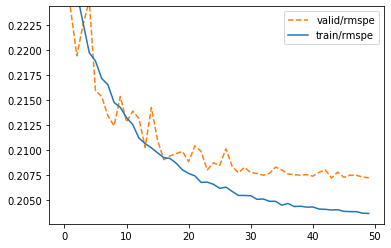

In [9]:
trainer.fit(model, train_dl, val_dl)

In [10]:
print(f'Best epoch {model.history["valid/rmspe"].argmin()}: {model.history["valid/rmspe"].min()}')

Best epoch 43: 0.20721854269504547


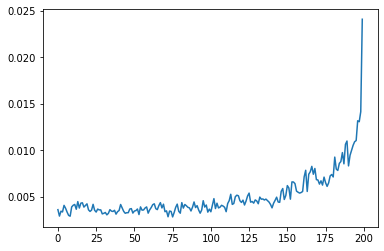

In [11]:
pd.Series(F.softmax(model.timesteps_attn.weights, 0).detach()).plot();

In [ ]:
!rm /kaggle/working/train.npy